# Project with Yuanyuan on Orientational Bias in Cluster Mass
### Created Jan, 2018
### Zhuowen Zhang

In [2]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()

# setup notebook for inline figures
%matplotlib inline

In [3]:
from code.setup.setup import data_home_dir
import pyfits
#Read http://pythonhosted.org/pyfits/

datadir = data_home_dir()

#RedMapper Galaxy cluster data
redM_data = datadir+'buzzard-0_1.6_y3_run_redmapper_v6.4.20_lgt20_vl02_catalog.fit'
redM_list = pyfits.open(redM_data)
redM_data = redM_list[1].data

print "Number of clusters is ", len(redM_data)



Number of clusters is  24243


### Extracting Halo and Cluster Files
From buzzard and Chinchilla in Slac_Stanford simulation repository

In [4]:
#Check rotation code for halos
import healpy as hp
import fitsio
from code.setup.setup import code_home_dir
import pickle


codedir = code_home_dir()

rotfile = codedir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)

angle = np.array([[np.pi/2,0.,np.pi,np.pi/2,0.,np.pi],[0.,0.,0.,np.pi/2,np.pi/2,np.pi/2]])
vec = hp.ang2vec(angle[0],angle[1])
rvec = np.dot(rmat, vec.T).T
rangle = np.asarray(hp.vec2ang(rvec))
#print 'theta, phi'
#print 'original angle \n', angle.T*180/np.pi
#print 'rotated angle \n', rangle.T*180/np.pi

#Rotate the angles back
my_vec = np.dot(np.linalg.inv(rmat),rvec.T).T
my_angle = np.asarray(hp.vec2ang(my_vec))
print 'Original angle', angle.T*180/np.pi
print 'My angle ', my_angle.T*180/np.pi



Original angle [[ 90.   0.]
 [  0.   0.]
 [180.   0.]
 [ 90.  90.]
 [  0.  90.]
 [180.  90.]]
My angle  [[9.00000000e+01 4.54015361e-16]
 [0.00000000e+00 2.34355739e+02]
 [1.80000000e+02 4.07559728e+00]
 [9.00000000e+01 9.00000000e+01]
 [0.00000000e+00 2.34355739e+02]
 [1.80000000e+02 8.79281675e+01]]


In [5]:
#Reading halo files
halo_filenum = [0,1,17,19,2,21,22,23,26,27,3,4,5,6,7]
halo_iter = np.shape(halo_filenum)[0]

#halos_data, the rec_array that combines all halo files, reads from first halo file, and then stacks to it.
halo_data = datadir+'Chinchilla-0_halos.'+str(halo_filenum[0])+'.fits'
halo_list = pyfits.open(halo_data)
cols = halo_list[1].data.columns
halos_data = pyfits.FITS_rec.from_columns(cols) #stores as record array

#check that halos_data match halo_data
print 'number of rows in halo_data/halos_data (initial) ', len(halos_data) 

#check that files_num has rows totaling the number of rows combined from each halo file
tot_row = np.append(0,halos_data.shape[0])

#Iterate through rest of halo files. Each iteration creates a new and updated halos_file record array
#with new rows added that correspond to data from each halo file.
for i in xrange(1,halo_iter):
    halo_data = datadir+'Chinchilla-0_halos.'+str(halo_filenum[i])+'.fits'
    halo_list = pyfits.open(halo_data)
    halo_data = halo_list[1].data

    nrows1 = halos_data.shape[0]
    nrows2 = halo_data.shape[0]
    nrows = nrows1 + nrows2
    tot_row = np.append(tot_row, nrows)
    
    #Warning: from_columns appends rows to halos_data, but does not update column array. Need to manually 
    #copy data each time. Inefficient code, but will do. 
    copy_halos_data = pyfits.FITS_rec.copy(halos_data) #Need to make copy of previous halos_data
    halos_data = pyfits.FITS_rec.from_columns(halos_data, nrows=nrows, fill=False) #Warming: Does not update column data in halos_data
       
    #Fill in the extra rows with data from new halo file
    for colname in halo_data.columns.names:
        halos_data[colname][:nrows1] = copy_halos_data[colname]
        halos_data[colname][nrows1:] = halo_data[colname]
    #halos_data = pyfits.FITS_rec.copy(halos_data)
    print "Halo file number ", halo_filenum[i]
    #print "Test for repeat halos_data['Z']", halos_data['Z'][nrows1:nrows1+20]
    #print 'ID of halos_data.column', id(halos_data.column)
#print halos_data['Z'][tot_row[1]:tot_row[1]+100], nrows1, tot_row[2]


number of rows in halo_data/halos_data (initial)  1169087
Halo file number  1
Halo file number  17
Halo file number  19
Halo file number  2
Halo file number  21
Halo file number  22
Halo file number  23
Halo file number  26
Halo file number  27
Halo file number  3
Halo file number  4
Halo file number  5
Halo file number  6
Halo file number  7


In [6]:
#Check that halos_file is combining the files properly.
#For more info on record arrays, pyFITS:
#https://pythonhosted.org/pyfits/usage/table.html#table-data-as-a-record-array
#http://pythonhosted.org/pyfits/api/tables.html#pyfits.FITS_rec

#Check 1: Field values match that in the last halo file read
test_num = 14
halo_data = datadir+'Chinchilla-1_halos_lensed.'+str(halo_filenum[test_num])+'.fits'
halo_list = pyfits.open(halo_data)
halo_data = halo_list[1].data
#print 'Values for column name \'Z\' for halos_data and same halo file'
#print halos_data['Z'][tot_row[test_num]:tot_row[test_num]+50:]
#print halo_data['Z'][0:50]
#print tot_row

#Check 2: The length of halos_file equals that of all halo_file rows combined.
if tot_row[-1] == len(halos_data):
    print "Number of rows match. It is ", len(halos_data)
    
#Check 3: Read the columns names and type of halos_data to see if makes sense. They do by inspection
#print halos_data.columns
#halo_data.columns
#halos_data['ID'][5000:5100]



Number of rows match. It is  14038831


## Randomly select halos

In [15]:
import numpy.random as rand

#First apply a redshift cut, and then randomly select in that redshift. 
z_cut = np.where(halos_data['Z'] < 0.34)
halos_rand = halos_data[z_cut]

#Select 10,000 random samples
num_rand = 10000
rand_samp = rand.randint(0,len(halos_rand), num_rand)
halos_rand = halos_rand[rand_samp]

#Retreive columns
halos_rand_ID = halos_rand['ID']; halos_rand_RA = halos_rand['RA'] 
halos_rand_DEC = halos_rand['DEC']; halos_rand_z = halos_rand['Z']
halos_rand_M = halos_rand['M200C']; halos_rand_Rvir = halos_rand['RVIR'] #in kpc
halos_rand_X = halos_rand['PX']; halos_rand_Y = halos_rand['PY']; halos_rand_Z = halos_rand['PZ']

name_str = ('halos_ID','halos_RA', 'halos_DEC', 'halos_z', 'halos_X', \
            'halos_Y', 'halos_Z', 'halos_M', 'halos_Rvir')
outfile = open('Halo_rand_zcut.dat','w')
outfile.write('%12s %12s %12s %12s %12s %12s %12s %12s %12s \n'%name_str)
for i in range(num_rand):
    outfile.write('%12d %12g %12g %12g %12g %12g %12g %12g %12g\n' \
                  %(halos_rand_ID[i], halos_rand_RA[i], halos_rand_DEC[i], halos_rand_z[i], \
                   halos_rand_X[i], halos_rand_Y[i], halos_rand_Z[i], halos_rand_M[i], halos_rand_Rvir[i]))
outfile.close()


### Halo and cluster matching algorithm


In [6]:
#Distance calculations for proximity matching
from colossus.cosmology import cosmology

#Q? Parameters need to change?
# define a vector of cosmological parameters of Via Lactea II cosmology:    
h = 0.73
my_cosmo = {'flat': True, 'H0': h*100, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.74, 'ns': 0.951}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)   

#Set to transverse or line of sight comoving distance? Can't tell. 
#comoving_r = cosmo.comovingDistance(zmin, zmax, transverse=True)

In [7]:
#Cut off halos with mass less than 10^13 M_sun
mass_cutoff = halos_data['M200C'] > 1e13
halos_data = halos_data[mass_cutoff]
print "After mass cut of M > 1e13 M_sun number of halos is ", len(halos_data)

After mass cut of M > 1e13 M_sun number of halos is  3926430


In [8]:
#Rotate the halo files
import healpy as hp
import fitsio
from code.setup.setup import code_home_dir
import pickle

codedir = code_home_dir()

#file containing the rotation matrix 
rotfile = codedir+'desy3_irot.pkl'

with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
#Read Test halos data
#halo_data = datadir+'Chinchilla-1_halos_lensed.'+str(halo_filenum[7])+'.fits'
#halo_list = pyfits.open(halo_data)
#cols = halo_list[1].data.columns
#halos_data = pyfits.FITS_rec.from_columns(cols) #stores as record array

halos_posvec = np.transpose([halos_data['PX'], halos_data['PY'], halos_data['PZ']])

halos_rposvec = np.dot(rmat, halos_posvec.T).T

#convert to angular coords (in Radians)
theta, phi = hp.vec2ang(halos_rposvec)
halos_data['DEC'] = np.pi/2 - theta
halos_data['RA'] = phi

print 'Halos DEC and RA \n', halos_data['DEC'], '\n', halos_data['RA']

Halos DEC and RA 
[-0.14301676 -0.12671012 -0.18712666 ..., -0.99164159 -1.04709575
 -1.08423815] 
[ 1.11150151  1.1738181   1.10024055 ...,  6.07248707  0.13348337
  0.21959056]


In [25]:
#Parameters for for matching
redM_ID = redM_data['MEM_MATCH_ID']
redM_RA = np.copy(redM_data['RA']); redM_DEC = np.copy(redM_data['DEC']); redM_z = np.copy(redM_data['Z_LAMBDA']) 
redM_lmda = np.copy(redM_data['LAMBDA_CHISQ']); 

halos_ID = halos_data['ID']; halos_RA = np.copy(halos_data['RA']) 
halos_DEC = np.copy(halos_data['DEC']); halos_z = np.copy(halos_data['Z'])
halos_M = np.copy(halos_data['M200C']); halos_Rvir = np.copy(halos_data['RVIR']) #in kpc
halos_X = np.copy(halos_data['PX']); halos_Y = np.copy(halos_data['PY']); halos_Z = np.copy(halos_data['PZ'])


#Convert RA, DEC to radians for redMapper. 
redM_RA *= np.pi/180.; redM_DEC *= np.pi/180.

#Convert from z to comoving distance in fiducial cosmology
redM_comvr = cosmo.comovingDistance(0.0,redM_z)
halos_comvr = cosmo.comovingDistance(0.0, halos_z)

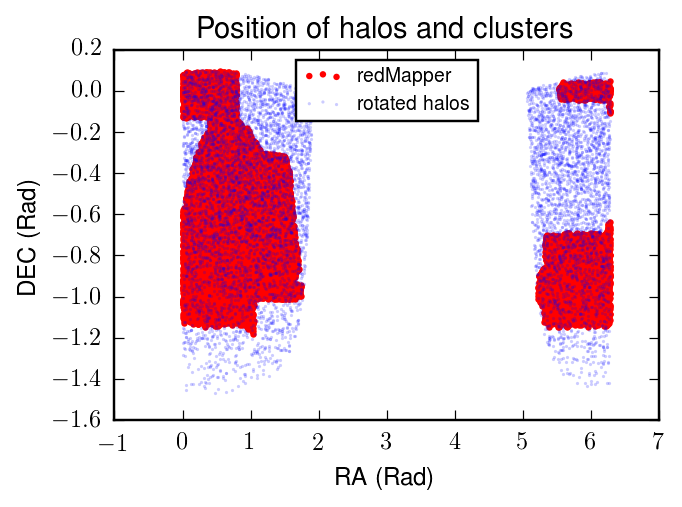

In [26]:
#Scatter plot to inspect that halos match clusters
plt.figure(figsize=(4,3))
plt.scatter(redM_RA, redM_DEC, c='r', s=7, marker='o',linewidth=0.0, label='redMapper')
plt.scatter(halos_RA[::500], halos_DEC[::500], c='b', marker='.', s=7, linewidth=0.0, alpha=0.2, label='rotated halos')
plt.xlabel('RA (Rad)'); plt.ylabel('DEC (Rad)')
plt.legend(fontsize=8, loc='upper center')
plt.title('Position of halos and clusters')
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

In [11]:
#Cluster matching algorithm: Go down list of halos, 
#from most to least massive, and find potential cluster matches

#Find sorted indices for halos_M
halos_sort=np.asarray(sorted(range(len(halos_M)),key=lambda x:halos_M[x],reverse=True))
print "Number of halos is ", halos_sort.shape[0]

cl_match_ind = np.array([]) #indices of (potentially) matched clusters 
cl_uniq_ind = np.array([]) #unique indices to select uniquely matched clusters
for i in range(halos_sort.shape[0]):
    cur_halo_RA = halos_RA[halos_sort[i]]; cur_halo_DEC = halos_DEC[halos_sort[i]]
    cur_halo_comvr = halos_comvr[halos_sort[i]]; cur_halo_z = halos_z[halos_sort[i]]
    
    #Assume clusters that fall into this redshift range have the same redshift as the halo. 
    #Find the distance to the halo according to this assumption, and find ones local to the halo.
    
    #Find clusters within redshift bin of +/- 0.1 
    zbin = 0.05
    zbin_cl_ind = np.asarray(np.where(np.abs(cur_halo_z-redM_z)<zbin))
    
    #Filter clusters in redshift proximity region
    redM_DEC_zfilt = redM_DEC[zbin_cl_ind]; redM_RA_zfilt = redM_RA[zbin_cl_ind]
    
    #Angle difference from RA, DEC using spherical law of cosines
    d_lmda = redM_RA_zfilt - cur_halo_RA
    d_Sigma = np.arccos(np.sin(redM_DEC_zfilt)*np.sin(cur_halo_DEC)+\
                        np.cos(redM_DEC_zfilt)*np.cos(cur_halo_DEC)*np.cos(d_lmda))
    
    #comoving distance between halo and clusters from law of cosines
    #d_cmvr = np.sqrt(cur_halo_comvr**2.+redM_comvr**2. - 2.*redM_comvr*cur_halo_comvr*np.cos(d_Sigma))
    
    #comoving distance between halo and clusters from law of cosines for clusters in same comoving distance
    d_cmvr = np.sqrt(2*cur_halo_comvr**2.*(1.-np.cos(d_Sigma)))
    
    #find eligible local clusters based on proxmity, and remove repeat cluster already taken by higher mass halos
    max_d_cmvr = 1.0 #set to 1Mpc
    loc_cl_ind = zbin_cl_ind[np.where(d_cmvr<max_d_cmvr)]
    loc_cl_ind = np.setdiff1d(loc_cl_ind, cl_uniq_ind) #remove clusters already taken by higher mass halos
    
    #if local clusters present find richest one
    if np.size(loc_cl_ind) > 0:
        cur_cl_match_ind = loc_cl_ind[np.argmax(redM_lmda[loc_cl_ind])]
        cl_uniq_ind= np.append(cl_uniq_ind, cur_cl_match_ind)
    else:
        cur_cl_match_ind = -1 #-1 for no match
        
    cl_match_ind = np.concatenate((cl_match_ind, [cur_cl_match_ind]))
    
    if i%1e5 == 0:
        print "Matching halo number ", i
        #print 'cl_match indices are ', np.where(cl_match_ind > -1)
        #print 'd_cmvr ', d_cmvr[0:50]
        #print 'zbin_cl_ind is ', zbin_cl_ind
        
        #Check for duplicates
        #print 'Unique clusters indices are', cl_uniq_ind
        #dupes = [x for n, x in enumerate(cl_uniq_ind) if x in cl_uniq_ind[:n]]
        #print 'Duplicate clusters are ', dupes # [[1], [3]]

print 'Number of clusters matched to halos are ', np.shape(np.where(cl_match_ind>-1))[1]


Number of halos is  3926430
Matching halo number  0
Matching halo number  100000
Matching halo number  200000
Matching halo number  300000
Matching halo number  400000
Matching halo number  500000
Matching halo number  600000
Matching halo number  700000
Matching halo number  800000
Matching halo number  900000
Matching halo number  1000000
Matching halo number  1100000
Matching halo number  1200000
Matching halo number  1300000
Matching halo number  1400000
Matching halo number  1500000
Matching halo number  1600000
Matching halo number  1700000
Matching halo number  1800000
Matching halo number  1900000
Matching halo number  2000000
Matching halo number  2100000
Matching halo number  2200000
Matching halo number  2300000
Matching halo number  2400000
Matching halo number  2500000
Matching halo number  2600000
Matching halo number  2700000
Matching halo number  2800000
Matching halo number  2900000
Matching halo number  3000000
Matching halo number  3100000
Matching halo number  32000

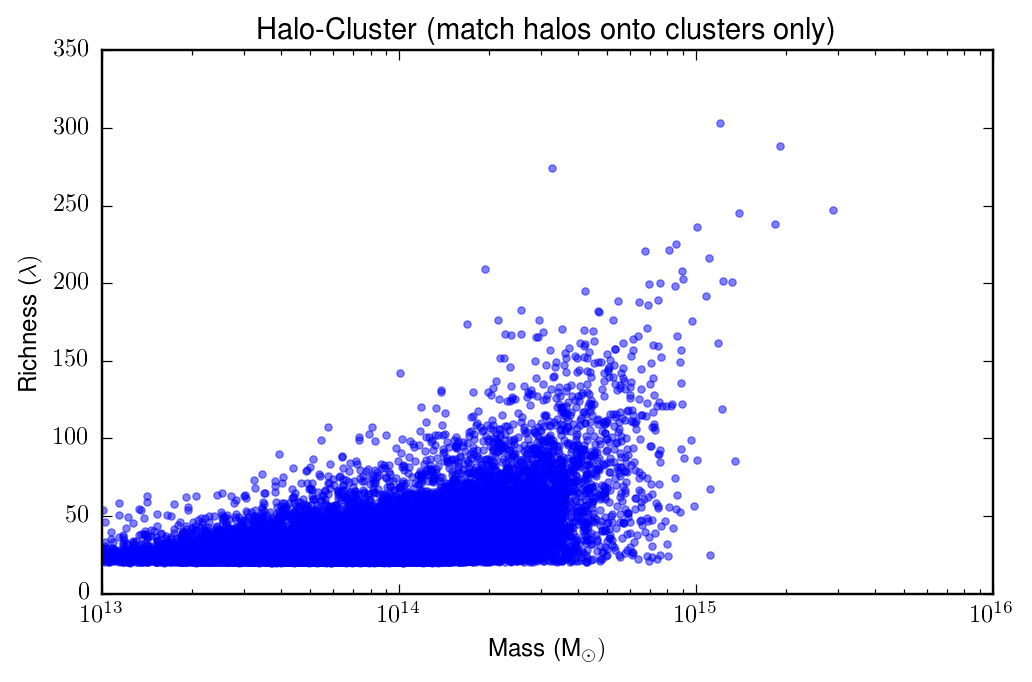

In [12]:
#Sample test of mass richness using matched clusters only
halos_match_ind = np.where(cl_match_ind != -1)
halos_M_match = halos_M[halos_sort[halos_match_ind]]
#print halos_match_ind
redM_lmda_match = redM_lmda[np.asarray(cl_match_ind[halos_match_ind],dtype=int)]
plt.plot(halos_M_match, redM_lmda_match, '.', alpha=0.5)
plt.xscale('log')
plt.title('Halo-Cluster (match halos onto clusters only)')
plt.ylabel(r'Richness (\lambda)'); plt.xlabel(r'Mass (M_\odot)')
plt.tight_layout()
#plt.savefig('Halo_Cluster_clmatch_only.png')
plt.show()


In [13]:
#Halo matching algorithm: Go down list of redMapper clusters and find potential halo matches
#Repeat the same process for clusters. 
#Test and debug code. 

redM_sort=np.asarray(sorted(range(len(redM_lmda)),key=lambda x:redM_lmda[x],reverse=True))
print 'Number of redMapper clusters are ', len(redM_sort)
halos_match_ind = np.array([]) #indices of (potentially) matched halos 
halos_uniq_ind = np.array([])
for i in range(redM_data.shape[0]):
    cur_cl_RA = redM_RA[redM_sort[i]]; cur_cl_DEC = redM_DEC[redM_sort[i]]
    cur_cl_comvr = redM_comvr[redM_sort[i]]; cur_cl_z = redM_z[redM_sort[i]]
    
    #Assume clusters that fall into this redshift range have the same redshift as the halo. 
    #Find the distance to the halo according to this assumption, and find ones local to the halo.
    
    #Find clusters within redshift bin of +/- 0.05 
    zbin = 0.05
    zbin_halos_ind = np.asarray(np.where(np.abs(halos_z-cur_cl_z)<zbin))
    
    #Filter clusters in redshift proximity region
    halos_DEC_zfilt = halos_DEC[zbin_halos_ind]; halos_RA_zfilt = halos_RA[zbin_halos_ind]
    
    #Angle difference from RA, DEC using spherical law of cosines
    d_lmda = halos_RA_zfilt - cur_cl_RA
    d_Sigma = np.arccos(np.sin(halos_DEC_zfilt)*np.sin(cur_cl_DEC)+\
                        np.cos(halos_DEC_zfilt)*np.cos(cur_cl_DEC)*np.cos(d_lmda))
    
    #comoving distance between halo and clusters from law of cosines for clusters in same comoving distance
    d_cmvr = np.sqrt(2*cur_cl_comvr**2.*(1.-np.cos(d_Sigma)))
    
    #find local clusters
    max_d_cmvr = 1.0 #set to 1Mpc
    loc_halos_ind = zbin_halos_ind[np.where(d_cmvr<max_d_cmvr)]
    loc_halos_ind = np.setdiff1d(loc_halos_ind, halos_uniq_ind) #remove halos taken by richer clusters
    
    #if local halos present find most massive one
    if np.size(loc_halos_ind) > 0:
        cur_halos_match_ind = loc_halos_ind[np.argmax(halos_M[loc_halos_ind])]
        halos_uniq_ind = np.append(halos_uniq_ind, cur_halos_match_ind)
    else:
        cur_halos_match_ind = -1 #-1 for no match
        
    halos_match_ind = np.concatenate((halos_match_ind, [cur_halos_match_ind]))
    
    if i%1e3 == 0:
        print "Matching cluster number ", i
        #print 'Halo_match indices are ', np.where(halos_match_ind > -1)
                              
        #Check for duplicates
        #print 'Unique halo indices are', halos_uniq_ind
        #dupes = [x for n, x in enumerate(cl_uniq_ind) if x in cl_uniq_ind[:n]]
        #print 'Duplicate clusters are ', dupes # [[1], [3]]

print 'Number of halos matched to clusters are ', np.shape(np.where(halos_match_ind>-1))[1]                    

Number of redMapper clusters are  24243
Matching cluster number  0
Matching cluster number  1000
Matching cluster number  2000
Matching cluster number  3000
Matching cluster number  4000
Matching cluster number  5000
Matching cluster number  6000
Matching cluster number  7000
Matching cluster number  8000
Matching cluster number  9000
Matching cluster number  10000
Matching cluster number  11000
Matching cluster number  12000
Matching cluster number  13000
Matching cluster number  14000
Matching cluster number  15000
Matching cluster number  16000
Matching cluster number  17000
Matching cluster number  18000
Matching cluster number  19000
Matching cluster number  20000
Matching cluster number  21000
Matching cluster number  22000
Matching cluster number  23000
Matching cluster number  24000
Number of halos matched to clusters are  24000


(24000,) (24000,)


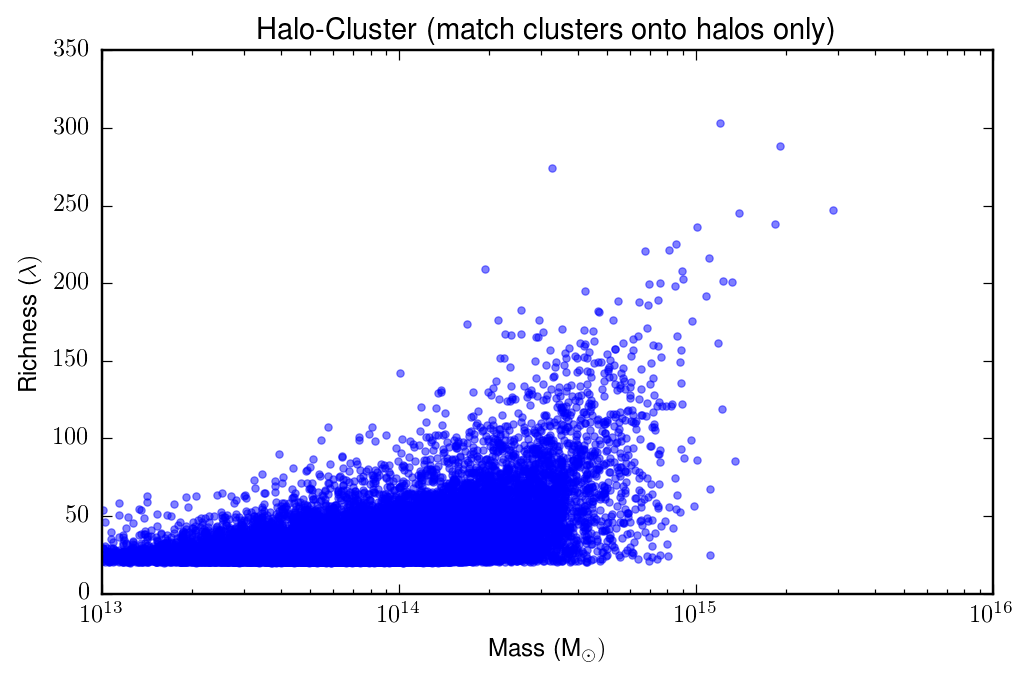

In [14]:
clusters_match_ind = np.where(halos_match_ind != -1)
redM_lmda_match = redM_lmda[redM_sort[clusters_match_ind]]
#print halos_match_ind
halos_M_match = halos_M[np.asarray(halos_match_ind[clusters_match_ind],dtype=int)]

print np.shape(halos_M_match), np.shape(redM_lmda_match)
plt.plot(halos_M_match, redM_lmda_match, '.', alpha=0.5)
plt.xscale('log')
plt.title('Halo-Cluster (match clusters onto halos only)')
plt.ylabel(r'Richness (\lambda)'); plt.xlabel(r'Mass (M_\odot)')
plt.tight_layout()
#plt.savefig('Halo_Cluster_halosmatch_only.png')
plt.show()

### Debugging


In [15]:
#Check logic of certain operators
a = np.random.random_integers(1,high=100,size=100)
#print a
b = sorted(range(len(a)),key=lambda x:a[x],reverse=True)
a_sorted = a[b]
a_unsorted = np.copy(a_sorted)
a_unsorted[b] = a_sorted

#c = np.array([1,2,3,4])
print a-a_unsorted

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 100 + 1) instead
  from ipykernel import kernelapp as app


In [16]:
#Check that in cl_match_ind the clusters matched to halos are physically adjacent. Check for redshift.
print "Check for cl_match_ind matching "
cl_match_ind_full = np.where(cl_match_ind != -1)
cl_zfilt = np.asarray(cl_match_ind[cl_match_ind_full], dtype=int)
halos_z_sorted = np.asarray(halos_z[halos_sort])
cl_zdiff =  halos_z_sorted[cl_match_ind_full] - redM_z[cl_zfilt]
#print cl_zdiff[0:50]
cl_z_excess = [x for i, x in enumerate(cl_zdiff) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(cl_z_excess), '\n'

#Repeat same code for halos
print "Check for halos_match_ind matching "
halos_match_ind_full = np.where(halos_match_ind != -1)
halos_zfilt = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
redM_z_sorted = np.asarray(redM_z[redM_sort])
halos_zdiff =  redM_z_sorted[halos_match_ind_full] - halos_z[halos_zfilt]
#print halos_zdiff[0:50]
halos_z_excess = [x for i, x in enumerate(halos_zdiff) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(halos_z_excess), '\n'

#See if the unsorting algorithm works as specified. cl_match_ind and halos_match_ind have indices sorted
#by halo mass and cluster rank. Once again check for redshift. 

#Find unsorted halos to match to clusters
print "Check for redM_match_ind_unsorted matching "
a = np.asarray(cl_match_ind[cl_match_ind_full], dtype=int)
b = np.asarray(halos_sort[cl_match_ind_full], dtype=int)
cl_zdiff2 = halos_z[b] - redM_z[a]
#print cl_zdiff2[0:50]
cl_z_excess2 = [x for i, x in enumerate(cl_zdiff2) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(cl_z_excess2), '\n'

#Find unsorted clusters to match to halos
print "Check for halos_match_ind_unsorted matching "
c = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
d = np.asarray(redM_sort[halos_match_ind_full], dtype=int)
halos_zdiff2 = redM_z[d] - halos_z[c]
#print halos_zdiff2[0:50]
halos_z_excess2 = [x for i, x in enumerate(halos_zdiff2) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(halos_z_excess2), '\n'

print 'Unsort full arrays and then check for match'
cl_match_ind_unsorted = np.array(cl_match_ind, dtype=int)
cl_match_ind_unsorted[halos_sort] = cl_match_ind

uniq_match_ind = np.where(cl_match_ind_unsorted != -1) #these refer to unsorted halos
uniq_match_val = cl_match_ind_unsorted[uniq_match_ind] #matched clusters to the unsorted halos
cl_zdiff3 = halos_z[uniq_match_ind] - redM_z[uniq_match_val]
#print cl_zdiff3[0:50]
cl_z_excess3 = [x for i, x in enumerate(cl_zdiff3) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(cl_z_excess3), '\n'

print "Check that uniq_match_ind are indeed same halos, albeit in wrong order"
a = halos_z[uniq_match_ind]
b = halos_z_sorted[cl_match_ind_full]
c = np.setdiff1d(a,b)
print 'Different halos in sorted and unsorted (order does not matter)', len(c)


Check for cl_match_ind matching 
Redshifts differences outside of specified range:  0 

Check for halos_match_ind matching 
Redshifts differences outside of specified range:  0 

Check for redM_match_ind_unsorted matching 
Redshifts differences outside of specified range:  0 

Check for halos_match_ind_unsorted matching 
Redshifts differences outside of specified range:  0 

Unsort full arrays and then check for match
Redshifts differences outside of specified range:  0 

Check that uniq_match_ind are indeed same halos, albeit in wrong order
Different halos in sorted and unsorted (order does not matter) 0


### Uniqueness matching algorithm
If a cluster matches onto a halo, and that halo matches onto the same cluster. 

In [17]:
cl_match_ind_unsorted = np.array(cl_match_ind, dtype=int)
cl_match_ind_unsorted[halos_sort] = cl_match_ind
halos_match_ind_unsorted = np.array(halos_match_ind, dtype=int)
halos_match_ind_unsorted[redM_sort] = halos_match_ind

uniq_match_ind = np.where(cl_match_ind_unsorted != -1) #these refer to unsorted halos
uniq_match_val = cl_match_ind_unsorted[uniq_match_ind] #matched clusters to the unsorted halos
nonuniq_match_val = [x for x in range(len(halos_match_ind_unsorted)) if x not in uniq_match_val] #assign all non_uniq halos to -1
uniq_match_bool = halos_match_ind_unsorted[uniq_match_val] == uniq_match_ind
uniq_match_bool = uniq_match_bool[0]
print 'Number of one way clusters matched to halos are ', np.shape(halos_match_ind_unsorted[uniq_match_val])
print 'Number of unique matches are ',np.shape(np.where(uniq_match_bool == True))

a = np.array(halos_match_ind_unsorted[uniq_match_val])
np.place(a , uniq_match_bool==False, -1)
halos_match_ind_unsorted[uniq_match_val] = a
halos_match_ind_unsorted[nonuniq_match_val] = -1
halos_uniq_ind_unsorted = np.copy(halos_match_ind_unsorted)


#Final cuts
redM_cut = np.where(halos_uniq_ind_unsorted != -1)
halos_cut = halos_uniq_ind_unsorted[redM_cut]

print 'After cutting out non-unique matched number of unique matches are', np.shape(np.where(halos_uniq_ind_unsorted != -1))


Number of one way clusters matched to halos are  (23995,)
Number of unique matches are  (1, 23914)
After cutting out non-unique matched number of unique matches are (1, 23914)


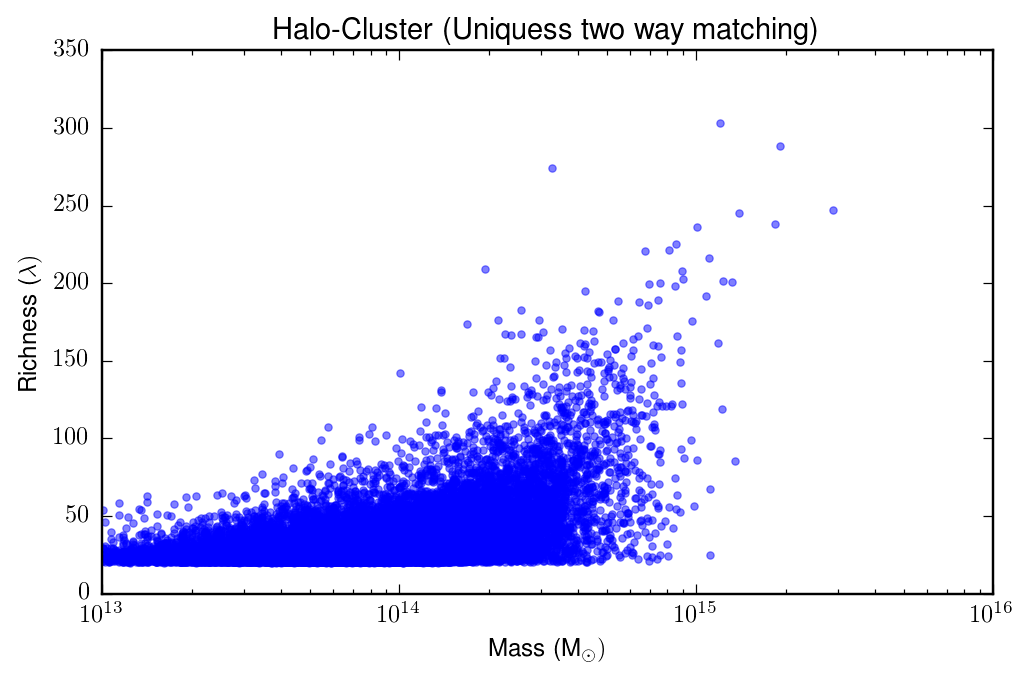

In [18]:
redM_lmda_uniq = redM_lmda[redM_cut]
halos_M_uniq = halos_M[halos_cut]

plt.plot(halos_M_uniq, redM_lmda_uniq, '.', alpha=0.5)
plt.xscale('log')
plt.title('Halo-Cluster (Uniquess two way matching)')
plt.ylabel(r'Richness (\lambda)'); plt.xlabel(r'Mass (M_\odot)')
plt.tight_layout()
#plt.savefig('Halo_Cluster_unique.png')
plt.show()

## Loading onto .dat file

In [19]:
#redM_data.columns

In [38]:
redM_ID_cut = redM_ID[redM_cut]; redM_RA_cut = redM_RA[redM_cut]; redM_DEC_cut = redM_DEC[redM_cut]; redM_z_cut = redM_z[redM_cut]; redM_lmda_cut = redM_lmda[redM_cut]
halos_ID_cut = halos_ID[halos_cut]; halos_RA_cut = halos_RA[halos_cut]; halos_DEC_cut = halos_DEC[halos_cut]; halos_z_cut = halos_z[halos_cut]; halos_M_cut = halos_M[halos_cut]
halos_Rvir_cut = halos_Rvir[halos_cut]; halos_X_cut = halos_X[halos_cut]; halos_Y_cut = halos_Y[halos_cut]; halos_Z_cut = halos_Z[halos_cut]
#RA,DEC are in rad. Convert back to degrees
redM_RA_cut *= 180./np.pi; redM_DEC_cut *= 180./np.pi; halos_RA_cut *= 180./np.pi; halos_DEC_cut *= 180./np.pi

#halos_RVir in Kpc/h. Convert to Mpc/h
halos_Rvir_cut /= 1000

name_str = ('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', \
            'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', \
            'halos_M', 'halos_Rvir')
outfile = open('Halo_redM_matched.dat','w')
outfile.write('%12s %12s %12s %12s %12s %12s %12s %12s %12s %12s %12s %12s %12s %12s \n'%name_str)
match_num = len(redM_ID_cut)
for i in range(match_num):
    outfile.write('%12d %12g %12g %12g %12g %12d %12g %12g %12g %12g %12g %12g %12g %12g\n' \
                  %(redM_ID_cut[i], redM_RA_cut[i], redM_DEC_cut[i], redM_z_cut[i], redM_lmda_cut[i], \
                   halos_ID_cut[i], halos_RA_cut[i], halos_DEC_cut[i], halos_z_cut[i], \
                    halos_X_cut[i], halos_Y_cut[i], halos_Z_cut[i], halos_M_cut[i], halos_Rvir_cut[i]))

outfile.close()

In [36]:
#print halos_ID_cut[0:100]
outfile.close()

[110385189 121756092 124235235 117984265 117180799 117120310 129700493
 123302212 115444861 116410935 116529553 117299630 124115537 124350816
 116471178 122597857 116350459 124408529 123546326 129642492 109524535
 122776417 123664066 128911594 123484511 128853189 123484500 128969736
 122657268 116410991 116411519 124519259 123423411 129757696 128054509
 118158018 129757837 109641419 125006417 111230821 128733972 117300661
 129700837 124350956 130578890 122657600 117299817 124235552 110385247
 127875273 122717810 139806483 129642574 122717562 130578678 117299673
 123722588 118872690 124293299 117865971 124464851 117299714 129814589
 124575120 116410786 110031107 122657198 124464743 118043497 124575117
 123545474 118214243 125120643 130409461 128169989 117180965 110385358
 124115601 123664285 118043565 128853413 117414053 117357577 118701804
 129083583 128911762 128054564 124350903 110031198 123664161 125063771
 118043537 118701842 117805755 124949721 117414051 124951123 129701059
 12451